In [1]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.optimize import minimize_scalar

##  Illustration de la m√©thode de simulation d‚Äôun processus de Poisson homog√®ne ou inhomog√®ne par la m√©thode de thinning
---

## Objectif

Ce notebook a pour but d‚Äôillustrer la simulation de **processus de Poisson**, qu‚Äôils soient **homog√®nes** ou **inhomog√®nes**, √† l‚Äôaide de la m√©thode de **thinning** (*√©chantillonnage par acceptation/rejet*).

Les processus de Poisson permettent de mod√©liser des √©v√©nements al√©atoires dans le temps (ou l‚Äôespace) comme :
- des appels t√©l√©phoniques,
- des crises m√©dicales,
- des ph√©nom√®nes naturels comme l‚Äôactivit√© volcanique.

Dans un **processus de Poisson homog√®ne**, les √©v√©nements surviennent √† une fr√©quence constante `Œª`.  
Dans un **processus inhomog√®ne**, cette intensit√© `Œª(t)` varie au cours du temps.

La m√©thode du **thinning**, introduite par Lewis & Shedler (1979), permet de simuler un processus inhomog√®ne √† partir d‚Äôun processus homog√®ne de taux maximal.

---

### Plan du notebook

1. **Defintions math√©matiques**
    - Processus de Poisson homog√®ne
    - Processus de Poisson inhomog√®ne
    - M√©thode du thinning
   


2. **Impl√©mentation des outils de simulation**
   - G√©n√©ration de processus homog√®nes (`p_ponctuel`, `p_comptage`)
   - Fonction de maximisation
   - Fonction `poisson_inhomogene_thinning`
     
3. **√âtude de diff√©rentes intensit√©s `Œª(t)`**
   - Constante
   - Sinuso√Ødale
   - Exponentielle d√©croissante
   - Gaussienne
   - Lin√©aire croissante
   - Graphes avec `Œª(t)` + √©v√©nements accept√©s / rejet√©s

4. **Cas d‚Äô√©tude r√©aliste**
   - Activit√© volcanique
   - Activit√© sur une plateforme de streaming audio 
   - Urgences p√©diatriques

5. **Conclusion**
   - Limites de la m√©thode
   - Ouvertures possibles


## 1. Defintions math√©matiques

### Processus de Poisson ‚Äì Formulation math√©matique

####  Processus de Poisson homog√®ne

Un **processus de Poisson homog√®ne** `(N(t))` d‚Äôintensit√© `Œª` (constante), d√©fini pour `t ‚â• 0`, est construit √† partir des temps d‚Äôarriv√©e :

T‚Çô = S‚ÇÅ + S‚ÇÇ + ... + S‚Çô avec T‚ÇÄ = 0,


o√π les `S·µ¢` sont des variables al√©atoires ind√©pendantes et identiquement distribu√©es (**i.i.d.**) suivant une loi **exponentielle de param√®tre `Œª`**.

Le processus s‚Äô√©crit :


                                            N(t) = sup { n | T‚Çô ‚â§ t }
                                        

Il compte le **nombre d‚Äô√©v√©nements survenus jusqu‚Äôau temps `t`**.

---

#### Processus de Poisson inhomog√®ne

Un **processus de Poisson inhomog√®ne** est d√©fini de mani√®re analogue, sauf que l‚Äôintensit√© `Œª` devient une **fonction `Œª(t)`**, mesurable, positive et born√©e.  
Cette fonction permet de mod√©liser une **intensit√© qui varie dans le temps**.

---

### M√©thode du thinning (√©claircissement)

La m√©thode du *thinning* permet de simuler un processus de Poisson **inhomog√®ne** √† partir d‚Äôun processus **homog√®ne** d‚Äôintensit√© constante.

#### √âtapes :

1. G√©n√©rer un processus homog√®ne d‚Äôintensit√© `Œªmax`, un **majorant** de la fonction `Œª(t)` (on choisit `Œªmax` le plus petit possible, avec `Œª(t) ‚â§ Œªmax` pour tout `t`).

2. Pour chaque √©v√©nement simul√© √† l‚Äôinstant `t`, g√©n√©rer une variable al√©atoire `U ~ U([0,1])` (loi uniforme).

3. Si `U ‚â§ Œª(t)/Œªmax`, **accepter l‚Äô√©v√©nement** ; sinon, le **rejeter**.

---

Les √©v√©nements accept√©s forment alors un **processus de Poisson inhomog√®ne** d‚Äôintensit√© `Œª(t)`.

Cette m√©thode est simple, intuitive, et tr√®s utilis√©e pour simuler des processus temporels r√©els √† intensit√© variable.


## 2. Impl√©mentation des outils de simulation

In [6]:
def p_ponctuel(lambd, seuil):
    debut = 0
    nb = []

    while debut < seuil:
        saut = rng.exponential(1 / lambd)
        debut += saut
        if debut < seuil:
            nb.append(debut)

    return np.array(nb)


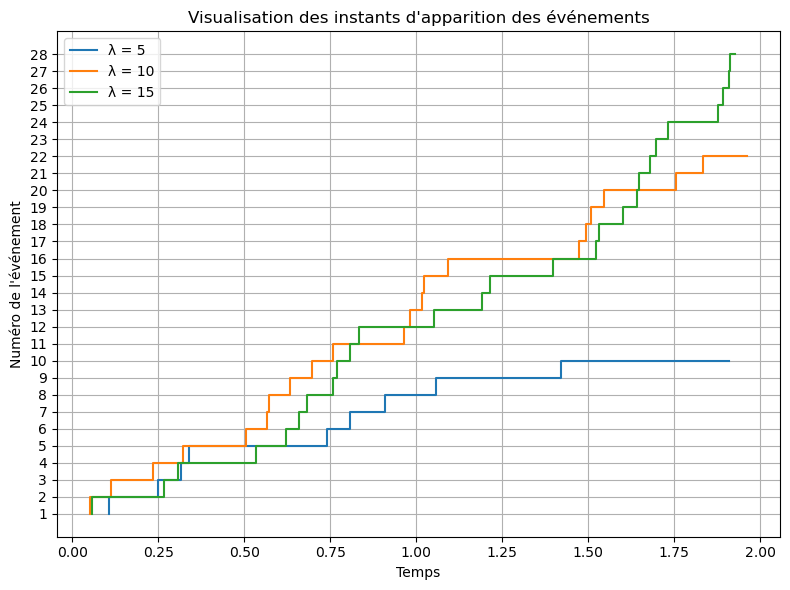

In [7]:
lambd = [5,10,15]
seuil = 2
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    
    issue = p_ponctuel(lambd[i], seuil)
    ax.step(issue, np.arange(1, len(issue)+1), label=f"Œª = {lambd[i]}")
ax.set_title("Visualisation des instants d'apparition des √©v√©nements")
ax.set_xlabel("Temps")
ax.set_ylabel("Num√©ro de l'√©v√©nement")
ax.set_yticks(np.arange(1, len(issue)+1))
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


#### Visualisation des √©v√©nements g√©n√©r√©s par `p_ponctuel`

Le graphique ci-dessus montre l‚Äôordre d‚Äôapparition des √©v√©nements d‚Äôun processus de Poisson homog√®ne simul√© avec `Œª = 5` ,  `Œª = 10` et `Œª = 15`sur l‚Äôintervalle `[0, 2]`.

Chaque marche correspond √† un √©v√©nement.  
Les temps d‚Äôattente suivant une loi exponentielle, on a donc un escalier irregulier, montrant bien la nature al√©atoire du processus.

On remarque bien que la courbe monte plus vite pour `Œª = 15`(√©v√©nement n¬∞18 √† t = 1), que  `Œª = 10` (√©v√©nement n¬∞9 √† t = 1) et encore plus vite que pour    `Œª = 5` (√©v√©nement n¬∞6 √† t = 1) 


In [9]:
def p_comptage(lambd, seuil):
    ponctuel = p_ponctuel(lambd, seuil)
    x = np.linspace(0, seuil, 1000)
    comptage = np.array([np.sum(ponctuel <= xi) for xi in x])
    return ponctuel, x, comptage 



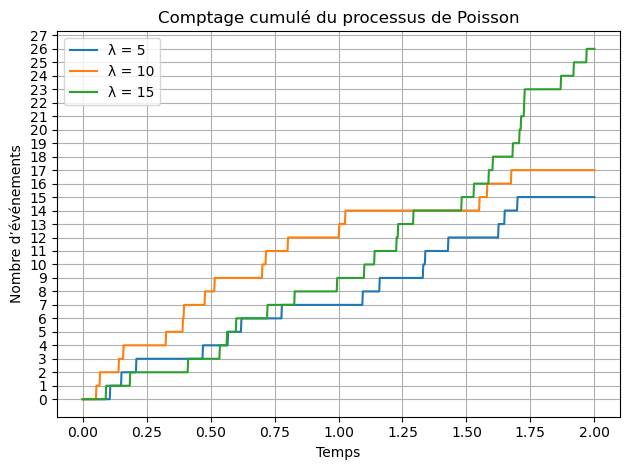

In [10]:

fig, ax = plt.subplots()
for i in range(3):
    ponctuel, x, comptage = p_comptage(lambd[i], seuil)
    ax.plot(x, comptage, label=f"Œª = {lambd[i]}")
ax.set(xlabel="Temps", ylabel="Nombre d‚Äô√©v√©nements", title="Comptage cumul√© du processus de Poisson")
ax.set_yticks(range(0, int(max(comptage)) + 2))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



#### Comptage cumul√© d‚Äôun processus de Poisson homog√®ne

Le graphique ci-dessus montre l'√©volution du **nombre total d‚Äô√©v√©nements** dans un **processus de Poisson homog√®ne** simul√© pou  plusieurs intensit√©s constante  `Œª = 5` ,  `Œª = 10` et `Œª = 15`, sur une dur√©e `T = 2`.

La courbe pour chaque `Œª` est une **fonction en escalier croissante** :
- Chaque saut correspond √† un **√©v√©nement qui se produit**.
- Les paliers horizontaux indiquent les **p√©riodes sans √©v√©nement**.
- La mont√©e irr√©guli√®re refl√®te le **caract√®re al√©atoire** du processus.



Ce graphique (`p_comptage`) ne montre pas **quand** chaque √©v√©nement se produit, mais **combien** ont eu lieu jusqu‚Äô√† chaque instant.

Contrairement au graphe bas√© sur `p_ponctuel`, qui affiche les **instants d‚Äôapparition individuels**, celui-ci permet de **suivre l'accumulation globale** des √©v√©nements dans le temps, ce qui est utile pour analyser le rythme d‚Äôapparition.


C‚Äôest donc une repr√©sentation plus synth√©tique du processus, adapt√©e aux comparaisons entre plusieurs intensit√©s `Œª`.
Cependant, on remarque bien une coh√©rence entre les deux graphiques car on remarque exactement la m√™me chose sur les deux , c'est √† dire que la courbe monte plus vite pour `Œª = 15`. Ce qui est tout a fait coh√©rent.


###  Simulation d‚Äôun processus de Poisson homog√®ne : `p_ponctuel` et `p_comptage`

Comme on l'a vu dans la partie 1, un **processus de Poisson homog√®ne** mod√©lise des √©v√©nements qui apparaissent al√©atoirement dans le temps, mais √† une fr√©quence constante `Œª` (appel√©e **intensit√©**).

Pour le simuler, on a donc cr√©√© deux fonctions compl√©mentaires :

`p_ponctuel(lambd, seuil)` : g√©n√®re les temps d‚Äôapparition des √©v√©nements. Ces temps sont obtenus en additionnant des intervalles al√©atoires tir√©s d‚Äôune loi exponentielle de param√®tre `Œª`, ce qui refl√®te la nature al√©atoire et sans m√©moire du processus.

`p_comptage(lambd, seuil)`: prend ces √©v√©nements et calcule, pour chaque point d‚Äôune grille de temps r√©guli√®re, le nombre total d‚Äô√©v√©nements survenus jusqu‚Äô√† ce moment. Cela permet de repr√©senter le comptage cumul√© du processus sous forme d‚Äôune courbe en escalier croissante.

Ensemble, ces deux fonctions permettent de g√©n√©rer un **processus de Poisson homog√®ne** dans un intervalle donn√© [0, seuil] ; et de visualiser comment le processus √©volue dans le temps, ce qui est essentiel pour l‚Äôanalyse statistique ou la comparaison avec un processus inhomog√®ne.

Ces deux fonctions vont nous servir de base pour pouvoir mod√©liser un **processus de Poisson inhomog√®ne avec la m√©thode du thinning.**

In [13]:
def maximum(f, borne_min=0, borne_max=100):
    def f_s√ªre(x):
        try:
            val = f(x)
            if not np.isfinite(val):
                return 1e10
            return -val
        except:
            return 1e10

    res = minimize_scalar(f_s√ªre, bounds=(borne_min, borne_max), method='bounded')
    return -res.fun



Cette fonction nous permer de trouver le **maximum** d'une fonction sur un intervalle (qu'on initialise par defaut √† [0,100]), cela nous permets de faciliter notre utilisation
de la **methode du thinning**

In [15]:
def poisson_inhomogene_thinning(f, seuil):
    lmax = maximum(f)
    √©v√©nements, _, _ = p_comptage(lmax, seuil)
    fx = f(√©v√©nements)
    unif = rng.uniform(size=len(√©v√©nements))
    acceptation = unif < fx / lmax
    accepted = √©v√©nements[acceptation]
    rejected = √©v√©nements[~acceptation]
    return accepted, rejected

Le code de notre fontion `poisson_inhomogene_thinning` nous donne acc√®s aux **points accept√©s et rejet√©s** par la methode du thinning.

## 3. √âtude de diff√©rentes intensit√©s `Œª(t)`

Dans cette partie , nous allons tester nos fonctions et donc **la methode du thinning** pour differentes fonctions `Œª`

In [19]:
lambda_const = lambda t: 5 * np.ones_like(t)
lambda_sin = lambda t: 5 + 3 * np.sin(2 * np.pi * t / 8)
lambda_exp = lambda t: 10 * np.exp(-0.5 * np.clip(t, a_min=0, a_max=None))
lambda_gauss = lambda t: 10 * np.exp(-((t - 5)**2) / (2 * 1.5**2))
lambda_lin = lambda t: 2 + 0.5 * t


In [20]:
def afficher_thinning(f, seuil, nom=""):

    accepted, rejected = poisson_inhomogene_thinning(f, seuil)

    ts = np.linspace(0, seuil, 1000)
    lambdas = f(ts)
    
    plt.figure(figsize=(12, 5))
    plt.plot(ts, lambdas, label="Œª(t) - Intensit√©", color='darkred', linewidth=2)
    plt.vlines(accepted,ymin =0.0 , ymax =1 ,color='blue', linestyle='-', alpha=0.8, linewidth=1, label="points accept√©s")
    plt.vlines(rejected,ymin =0.0 , ymax =1,color='green', linestyle='--', alpha=0.8, linewidth=1, label ="point rejet√©s")
    plt.axvline(x=seuil, color='black', linestyle='--', alpha=0.5, label='Seuil')

    plt.title(f"Thinning ‚Äì {nom}")
    plt.xlabel("Temps")
    plt.ylabel("Intensit√© / √âv√©nements")
    plt.ylim(0, np.max(lambdas) + 2)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




### Visualisation de la m√©thode du thinning

La fonction `afficher_thinning` nous permet de visualiser le r√©sultat de la m√©thode du *thinning* (`poisson_inhomogene_thinning`) qu'on a cod√© plus haut. 

---
Cette fonction va nous faciliter la visualisation de notre m√©thode. Elle nous permet d'afficher les √©l√©ments suivants :

- **Une courbe rouge** qui repr√©sente la fonction d‚Äôintensit√© `Œª(t)`.
- **Des traits verticaux bleus** qui correspondent aux √©v√©nements **accept√©s**, c‚Äôest-√†-dire ceux qui ont √©t√© conserv√©s apr√®s la m√©thode du thinning. Ils constituent le processus de Poisson inhomog√®ne simul√©.
- **Des traits verticaux verts en pointill√©s** qui repr√©sentent les √©v√©nements **rejet√©s** par la m√©thode du *thinning* : ils ont √©t√© g√©n√©r√©s par le processus homog√®ne de taux  `ùúÜmax`, mais √©limin√©s avec une certaine probabilit√©.( `Œª(t)/Œªmax` )
- **Une ligne verticale noire en pointill√©** qui marque le **seuil de simulation** (la limite temporelle qu'on a choisie).

---

Le graphique issue de cette fonction nous permettra de comprendre comment la densit√© des √©v√©nements accept√©s varie selon la forme de `ùúÜ` :
- Si `ùúÜ(t)` est √©lev√©e, on observe plus d'√©v√©nements bleus (accept√©s).
- Si `ùúÜ(t)` est faible, les √©v√©nements sont plus espac√©s et les rejets sont plus nombreux.



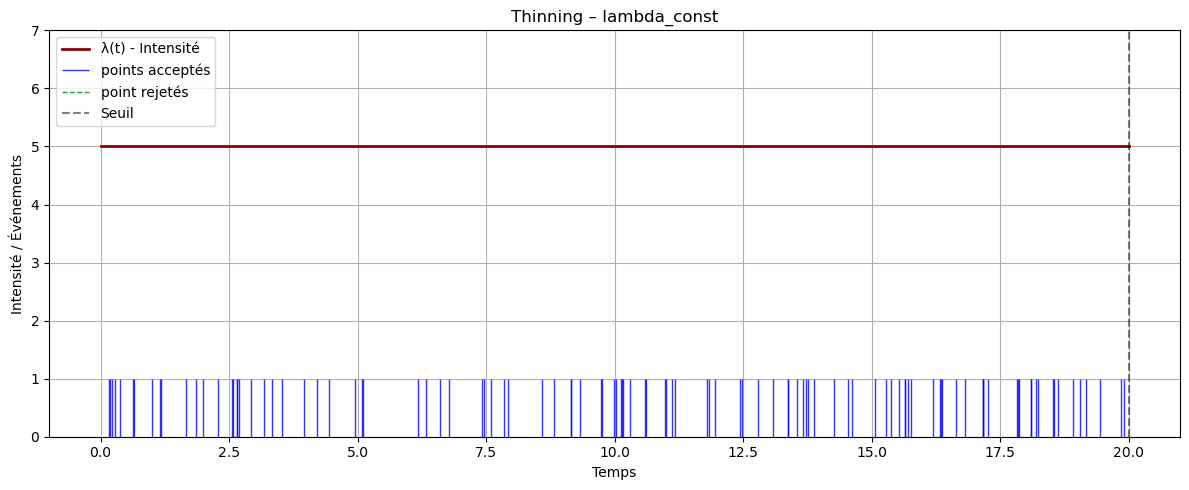

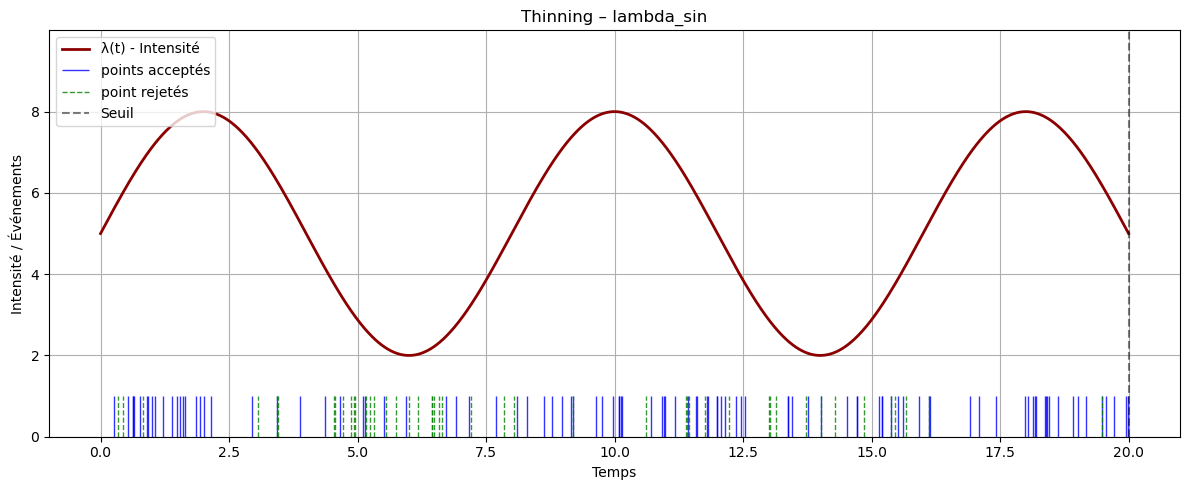

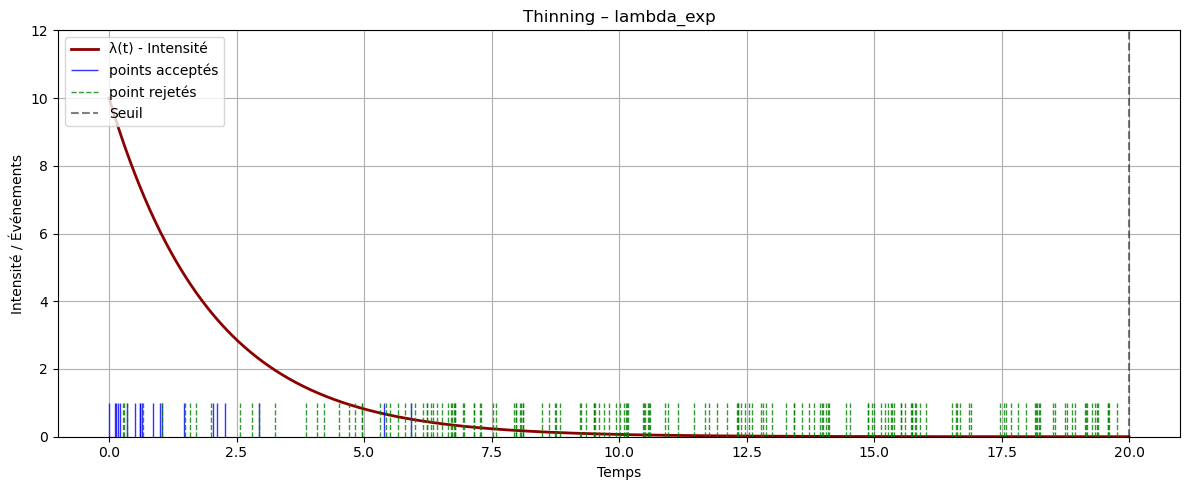

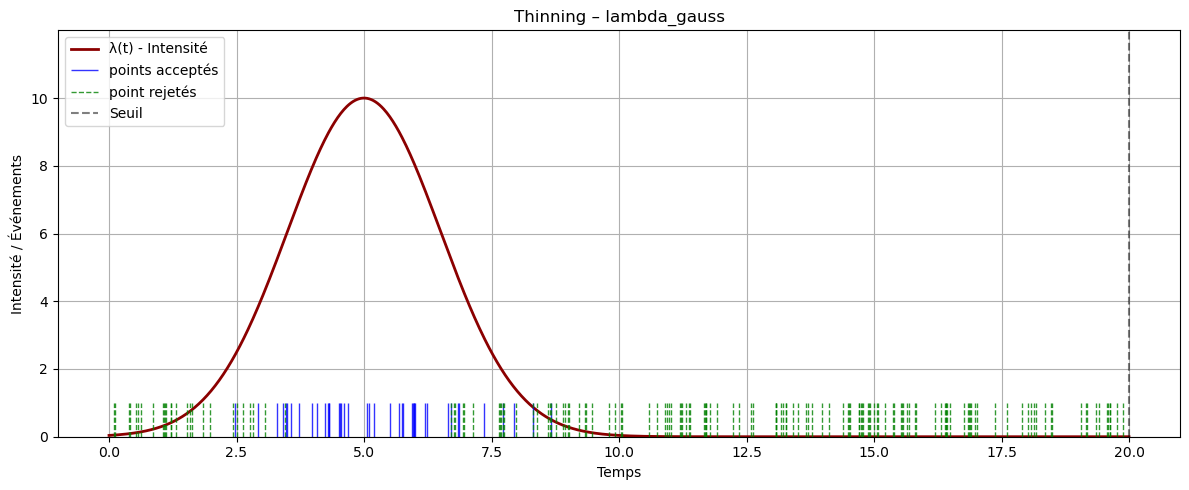

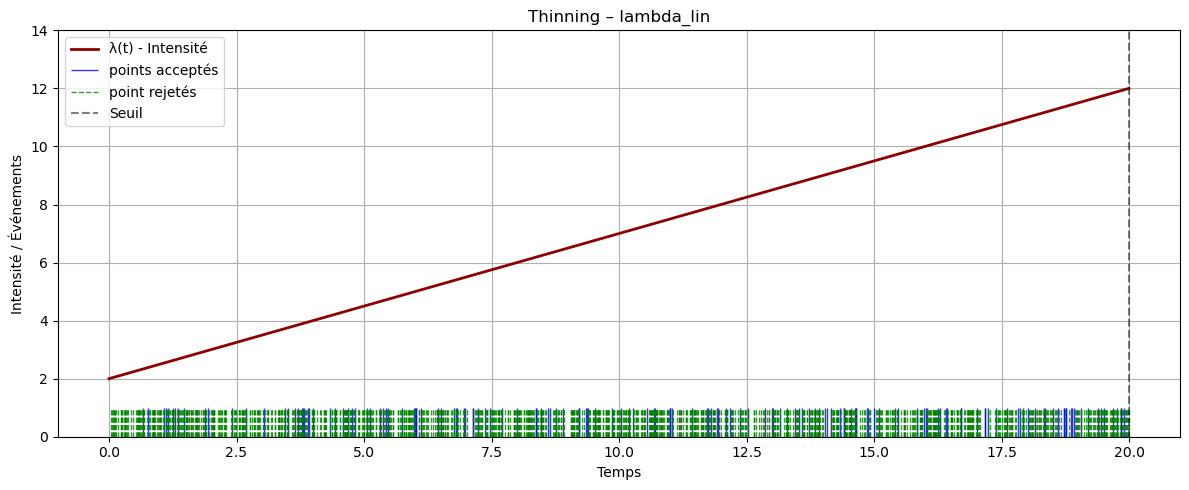

In [22]:
seuil2 = 20 #on augmente le seuil pour avoir plus d'√©v√©nements et mieux visualiser
lambdas = [("lambda_const", lambda_const),
    ("lambda_sin", lambda_sin),
    ("lambda_exp", lambda_exp),
    ("lambda_gauss", lambda_gauss),
    ("lambda_lin", lambda_lin)]
for nom , lambd in lambdas:
    afficher_thinning(lambd ,seuil2 , nom)



###### `lambda_const` : (ùúÜ(t) = 5)
- Intensit√© constante.
- Aucun √©v√©nement rejet√© (puisque ùúÜ(t) = ùúÜ(max) = 5 ).
- Les √©v√©nements sont **uniform√©ment r√©partis dans le temps**, ce qui donne un processus homog√®ne.

---

##### `lambda_sin` : (ùúÜ(t) =  5 + 3sin(2œÄt / 8))
- Intensit√© **p√©riodique** oscillant entre 2 et 8.
- Les √©v√©nements sont plus denses dans les zones o√π ùúÜ est haute.
- Beaucoup de **rejets** dans les creux de la sinuso√Øde (o√π l‚Äôintensit√© est faible).

---

##### `lambda_exp` : ( ùúÜ(t)= 10 exp(-0.5t))
- Intensit√© **d√©croissante** dans le temps.
- Forte densit√© d‚Äô√©v√©nements au d√©but, qui diminue progressivement.
- Cela illustre bien une **acc√©l√©ration suivie d‚Äôun ralentissement** du processus.

---

##### `lambda_gauss` : (ùúÜ(t) = 10exp(-((t - 5)¬≤)/(2 * 1.5¬≤)) )
- Forme en **cloche centr√©e** vers t = 5
- Les √©v√©nements sont concentr√©s **autour du pic**, comme pr√©vu.
- D√©but et fin de l‚Äôintervalle sont tr√®s peu actifs.

---

##### `lambda_lin` : ( ùúÜ(t) = 2 + 0.5t )
- Intensit√© **lin√©airement croissante** de 2 √† 4.5.
- Peu d‚Äô√©v√©nements au d√©but, et **densit√© croissante** dans le temps.
- Les rejets sont plus fr√©quents au d√©but, car la probabilit√© d'acceptation est plus faible.

---

##### Conclusion
Ces visualisations montrent clairement que la m√©thode du *thinning* permet de produire un processus de Poisson inhomog√®ne **fid√®le √† la fonction d‚Äôintensit√© ùúÜ(t)** impos√©e.  
Les √©v√©nements accept√©s respectent la variation locale de ùúÜ(t), tandis que les √©v√©nements rejet√©s assurent une coh√©rence statistique avec le processus homog√®ne initial.



On peut utiliser notre code pour modeliser des evenements inspir√© de la vie reelle comme une activit√© volcanique , l'activit√© su une plateforme de streaming ou  encore une urgence medicale!

## 4. Cas d‚Äô√©tude r√©aliste

### Modele d'intensit√© pour une activit√© volcanique

Pour mod√©liser l‚Äôactivit√© d‚Äôun volcan, on utilise une **somme de fonctions gaussiennes**, chaque gaussienne repr√©sentant une **√©ruption localis√©e dans le temps**.  

√Ä cela, on ajoute un **fond r√©siduel**, qui refl√®te l‚Äôactivit√© volcanique de base.  
En effet, en dehors des pics d‚Äô√©ruption, un volcan peut toujours produire :
- des **petites secousses**,
- des **retomb√©es de cendres**,
- ou d‚Äôautres ph√©nom√®nes mineurs.

Ce fond r√©siduel est g√©n√©ralement **faible** et **continu**, mais il est visuellement **√©cras√© lors des pics d‚Äô√©ruption**, car ceux-ci dominent largement l‚Äôintensit√© du processus √† ces moments-l√†.


Nous avons d√©cid√© de travailler sur l‚Äôactivit√© du volcan **Etna** sur une p√©riode de **12 mois**, correspondant √† l‚Äôann√©e **2025**.  
Durant cette ann√©e, plusieurs √©ruptions ont √©t√© recens√©es. Nous allons particuli√®rement nous int√©resser aux suivantes :

- **F√©vrier 2025** intensit√© : √©lev√©e
- **Avril 2025** intensit√© : mod√©r√©e
- **Juillet 2025** intensit√© : faible/mod√©r√©e 

Ces dates serviront de rep√®res pour mod√©liser l‚Äôintensit√© de l‚Äôactivit√© volcanique au cours de l‚Äôann√©e √† l‚Äôaide de pics gaussiens.
On va donc avoir un pic a t= 2 , t = 4 et t=7. Ensuite on choisi le facteur A, qui representera l'intensit√© de l'√©ruption , et pour finir œÉ qui representera la dur√©e.

Nos fonctions gaussiennes seront de la forme: 

                                                    f(x) = A*exp(-(x-t)¬≤/(2œÉ¬≤))

On peut remarquer qu‚Äôun facteur 2 a √©t√© ajout√© √† la fonction d‚Äôintensit√©.  
Cela permet d‚Äô**augmenter le nombre d‚Äô√©v√©nements simul√©s** sans modifier le param√®tre `seuil`, qui repr√©sente la **dur√©e totale de la simulation**
, ici 12 mois.  
Autrement dit, on **augmente la densit√© des √©v√©nements** sur le m√™me intervalle de temps.


In [63]:
def lambda_etna(t):
    t = np.array(t)
    eruption1 = 10 * np.exp(-((t - 2)**2) / (2 * 0.5**2))
    eruption2 = 5 * np.exp(-((t - 4)**2) / (2 * 0.7**2))
    eruption3 = 3 * np.exp(-((t - 7)**2) / (2 * 0.9**2))
    # Activit√© r√©siduelle lente
    fond = 1 + 1.5 * np.exp(-0.4 * t)
    return 2*(eruption1 + eruption2 + eruption3) +fond

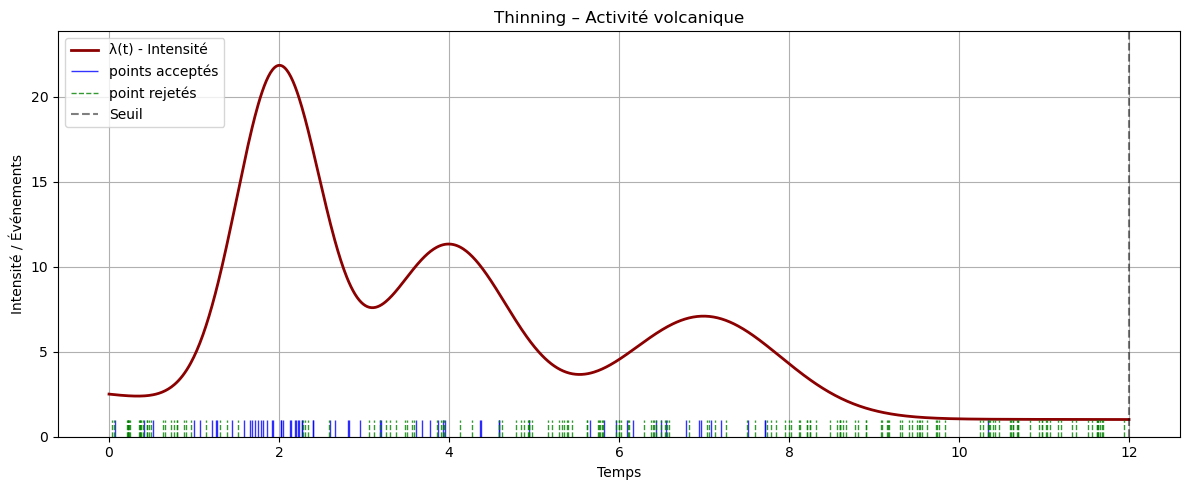

In [31]:
afficher_thinning(lambda_etna, seuil=12, nom="Activit√© volcanique")

- La m√©thode du **thinning** fonctionne bien : plus ùúÜ(t) est √©lev√©e, plus les √©v√©nements bleus sont denses.
- Les zones calmes (fin d‚Äôann√©e) montrent peu d‚Äô√©v√©nements accept√©s mais encore quelques rejets ‚Üí l‚Äôactivit√© de fond est mod√©lis√©e.
---
Ce mod√®le simule donc l'activit√© volcanique de l'Etna en 2025, avec des pics soudains et une base continue.


 ### Mod√©le d'intensite - Activit√© sur une plateforme de streaming audio 


Dans ce mod√®le, nous cherchons √† mod√©liser le nombre d‚Äôutilisateurs connect√©s √† une plateforme  au cours d‚Äôune journ√©e.


Voici les hypoth√®ses retenues sur l‚Äôaffluence en fonction des moments de la journ√©e :

- Faible activit√© la nuit (0h‚Äì6h),
- Mont√©e progressive le matin (7h‚Äì9h),
- Baisse l√©g√®re en milieu de journ√©e,
- Forte activit√© en soir√©e (18h‚Äì22h),
- Retomb√©e progressive apr√®s 23h.

Ce comportement cyclique et naturel est bien repr√©sent√© par une fonction **sinuso√Ødale**. Parce qu‚Äôun sinus varie r√©guli√®rement entre un minimum et un maximum.

La forme g√©n√©rale du sinus est :
                                         
                                                    Œª(t)=A+B‚ãÖsin(2œÄ/T*(t‚àíx))
Avec 

A : Niveau moyen (valeur au centre de l‚Äôoscillation)

B : Amplitude (variation au-dessus et en dessous du niveau moyen)

T : P√©riode (en combien d‚Äôunit√©s de temps on fait un cycle complet)

x : D√©calage horizontal (pour placer le pic o√π l'on veux)

---


##### Choix des param√®tres pour le mod√®le sinuso√Ødal

Dans notre cas, on souhaite mod√©liser une activit√© **cyclique sur une journ√©e compl√®te (24h)**.  
Voici les param√®tres choisis pour construire la fonction d‚Äôintensit√© sinuso√Ødale \( \lambda(t) \) :

- **P√©riode** ( T = 24 ) : un cycle complet en 24 heures.
- **Valeur moyenne** ( A = 4 ) : niveau d‚Äôactivit√© moyen au cours de la journ√©e.
- **Amplitude** ( B = 3 ) : variation entre un minimum de ( A - B = 1 ) et un maximum de ( A + B = 7 ).
- **D√©calage** ( x = 6 ) : pour faire en sorte que le **pic d‚Äôactivit√© se produise √† ( t = 18 )**.




In [36]:
def lambda_streaming(t):
    t = np.array(t)
    return 4 + 3 * np.sin(2 * np.pi * (t - 6) / 24)

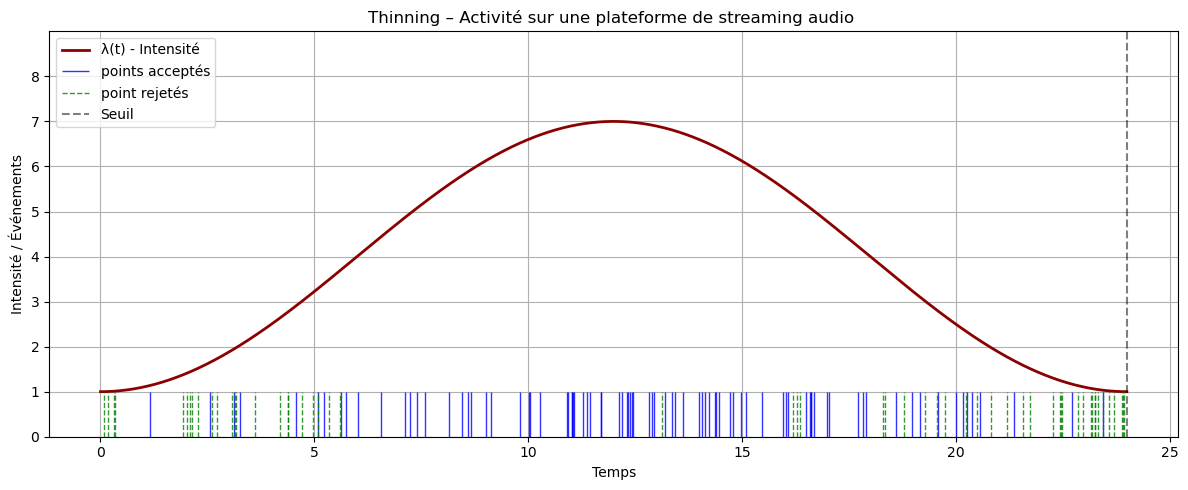

In [37]:
afficher_thinning(lambda_streaming, seuil=24, nom="Activit√© sur une plateforme de streaming audio ")

- Les √©v√©nements bleus sont **concentr√©s autour du pic** d‚Äôintensit√©, ce qui est logique : plus la fonction d'intensit√© est √©lev√©e, plus la probabilit√© d'accepter un √©v√©nement est forte.
- Inversement, peu d‚Äô√©v√©nements sont accept√©s la nuit, ce qui refl√®te bien une **baisse d‚Äôactivit√© r√©elle**.
- On observe √©galement que la densit√© des **points rejet√©s** augmente l√† o√π l‚Äôintensit√© est basse, ce qui montre que le processus homog√®ne g√©n√®re trop d'√©v√©nements dans ces zones, mais que le thinning filtre correctement.

---

Ce mod√®le illustre donc parfaitement un **ph√©nom√®ne d‚Äôusage cyclique**, comme l‚Äôactivit√© des utilisateurs sur une application, en lien avec leurs habitudes journali√®res.

### Mod√®le d‚Äôintensit√© - Urgences p√©diatriques


Dans ce mod√®le, nous cherchons √† repr√©senter le **nombre d‚Äôarriv√©es de patients aux urgences p√©diatriques** au cours d‚Äôune journ√©e typique (0h‚Äì24h), bas√© sur le fonctionnement observ√© dans des h√¥pitaux comme l‚Äôh√¥pital Armand-Trousseau (Paris), l‚Äôun des plus grands services d‚Äôurgences p√©diatriques d‚Äô√éle-de-France.

Voici les hypoth√®ses retenues sur l‚Äôaffluence au fil des heures :

- Faible activit√© durant la nuit (0h‚Äì6h),
- Mont√©e progressive des arriv√©es d√®s 6h du matin,
- Activit√© soutenue entre 12h et 17h,
- Pic d‚Äôactivit√© attendu en d√©but de soir√©e (vers 18h‚Äì20h),
- Diminution progressive apr√®s 22h.

---

Ce comportement **non cyclique mais asym√©trique** est mod√©lis√© par une combinaison :
- d'une **fonction logistique (tanh)** pour la mont√©e du matin,
- d'une **gaussienne** pour le pic de fin d‚Äôapr√®s-midi,
- et d'un **fond constant** pour simuler les cas nocturnes.

Nous utilisons la fonction tanh pour repr√©senter une **mont√©e progressive et r√©aliste** de l‚Äôintensit√© au fil du temps, notamment le matin.

-Le coefficient 0.6 contr√¥le la vitesse de mont√©e (plus il est grand, plus la mont√©e est rapide).

-Le d√©calage (t - 6) permet de commencer la mont√©e √† t = 6 (soit 6h du matin).

-Le facteur multiplicatif 2 ajuste l‚Äôamplitude de l‚Äôeffet du matin.


Afin d‚Äôaugmenter le nombre d‚Äô√©v√©nements simul√©s dans la m√™me plage temporelle, nous avons multipli√© les composantes de la fonction d‚Äôintensit√© par un facteur (√ó2), comme pour le mod√®le sur le volcan de l'Etna.


In [42]:

def lambda_trousseau(t):
    t = np.array(t)
    matin = 2 * np.tanh(0.6 * (t - 6)) 
    soir = 2.5 * np.exp(-0.1 * (t - 18)**2)  
    fond = 1  
    return fond +2* matin + 2*soir


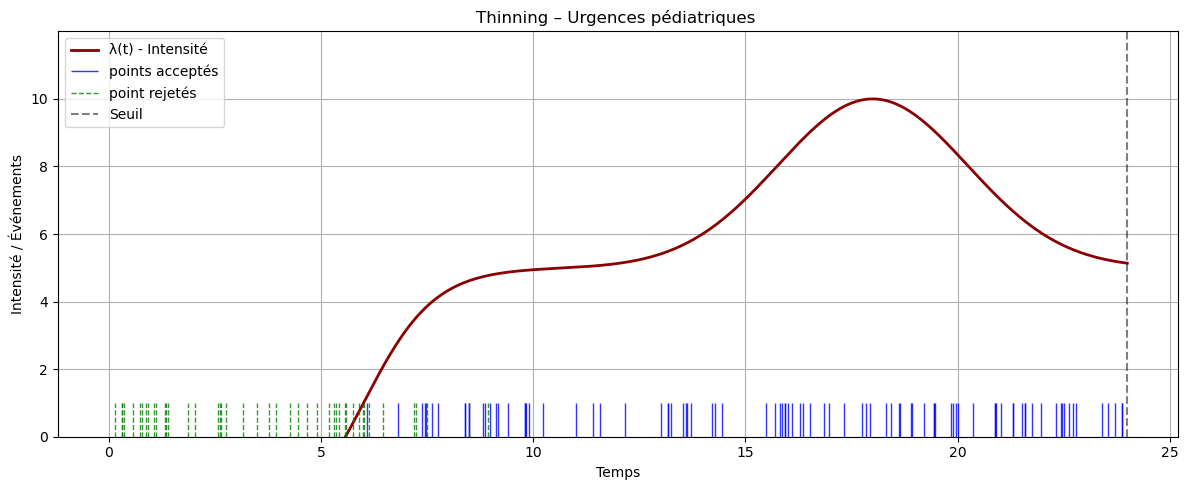

In [43]:
afficher_thinning(lambda_trousseau, seuil=24, nom="Urgences p√©diatriques ")

- Les √©v√©nements accept√©s se concentrent autour du **pic du soir**, ce qui valide que le mod√®le suit bien la dynamique voulue.
- Tr√®s peu d'√©v√©nements sont accept√©s pendant la nuit, ce qui refl√®te bien le **calme nocturne aux urgences**.
- Le **fond constant** garantit tout de m√™me quelques arriv√©es isol√©es m√™me lorsque \( \lambda(t) \) est bas.

---

Ce mod√®le montre la souplesse de la m√©thode de simulation par *thinning*, et son efficacit√© √† reproduire une intensit√© **r√©aliste, asym√©trique et adapt√©e √† un ph√©nom√®ne non p√©riodique**.


## 5. Conclusion

Pour conclure un **processus de poisson homog√®ne** est plus simple √† mod√©liser mais moins r√©aliste qu'un **processus inhomog√®ne** qui lui varie dans le temps (finance, trafic)

La m√©thode du thinning est une m√©thode efficace pour g√©n√©rer un processus inhomog√®ne car elle est :

-simple √† impl√©menter gr√¢ce aux g√©n√©rateurs standards

-g√©n√©rale car fonctionne avec une fonction d'intensit√© tant qu'elle est positive mesurable born√©e

-sans grand co√ªt num√©rique (pas besoin d'int√©grer de fonction ou d'inverser la fonction d'intensit√©)

Cependant elle peut avoir des inconv√©nients :

-si `Œªmax` est un trop grand majorant de la fonction d'intensit√©, il faudra g√©n√©rer beaucoup d'uniformes pour que les √©v√®nements soient accept√©s ce qui fait perdre du temps

-`Œªmax`  peut-√™tre difficile √† calculer si la fonction d'intensit√© poss√®de beaucoup de maximums locaux

-La m√©thode ne fonctionne pas si la fonction d'intensit√© n'est pas born√©e

Une autre m√©thode nomm√©e la m√©thode du temps transform√© qui consiste √† inverser la fonction d'intensit√© est aussi utilis√©e pour g√©n√©rer des processus de poisson inhomog√®nes, ainsi si la m√©thode du thinning est non possible ou moins efficace (fonction d'intensit√© non born√©e ou fonction d'intensit√© facile √† int√©grer et √† inverser) alors la m√©thode du temps transform√© sera plus utile.